In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st

plt.style.use('ggplot')

plt.rcParams['figure.dpi'] = 150

import missingno as msno

import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import f1_score , classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold


In [4]:
df = pd.read_csv('restaurant_menu_optimization_data.csv')

In [5]:
df.head()

,RestaurantID,MenuCategory,MenuItem,Ingredients,Price,Profitability
0,R003,Beverages,Soda,['confidential'],2.55,Low
1,R001,Appetizers,Spinach Artichoke Dip,"['Tomatoes', 'Basil', 'Garlic', 'Olive Oil']",11.12,Medium
2,R003,Desserts,New York Cheesecake,"['Chocolate', 'Butter', 'Sugar', 'Eggs']",18.66,High
3,R003,Main Course,Chicken Alfredo,"['Chicken', 'Fettuccine', 'Alfredo Sauce', 'Pa...",29.55,High
4,R002,Main Course,Grilled Steak,"['Chicken', 'Fettuccine', 'Alfredo Sauce', 'Pa...",17.73,Medium


In [6]:
def get_df_info(df):
    print("\n\033[1mShape of DataFrame:\033[0m ", df.shape)
    print("\n\033[1mColumns in DataFrame:\033[0m ", df.columns.to_list())
    print("\n\033[1mData types of columns:\033[0m\n", df.dtypes)
    
    print("\n\033[1mInformation about DataFrame:\033[0m")
    df.info()
    
    print("\n\033[1mNumber of unique values in each column:\033[0m")
    for col in df.columns:
        print(f"\033[1m{col}\033[0m: {df[col].nunique()}")
        
    print("\n\033[1mNumber of null values in each column:\033[0m\n", df.isnull().sum())
    
    print("\n\033[1mNumber of duplicate rows:\033[0m ", df.duplicated().sum())
    
    print("\n\033[1mDescriptive statistics of DataFrame:\033[0m\n", df.describe().transpose())

# Call the function
get_df_info(df)


Shape of DataFrame:  (1000, 6)

Columns in DataFrame:  ['RestaurantID', 'MenuCategory', 'MenuItem', 'Ingredients', 'Price', 'Profitability']

Data types of columns:
 RestaurantID      object
MenuCategory      object
MenuItem          object
Ingredients       object
Price            float64
Profitability     object
dtype: object

Information about DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RestaurantID   1000 non-null   object 
 1   MenuCategory   1000 non-null   object 
 2   MenuItem       1000 non-null   object 
 3   Ingredients    1000 non-null   object 
 4   Price          1000 non-null   float64
 5   Profitability  1000 non-null   object 
dtypes: float64(1), object(5)
memory usage: 47.0+ KB

Number of unique values in each column:
RestaurantID: 3
MenuCategory: 4
MenuItem: 16
Ingredients: 4
Price: 767
Profitability: 3


<Axes: >

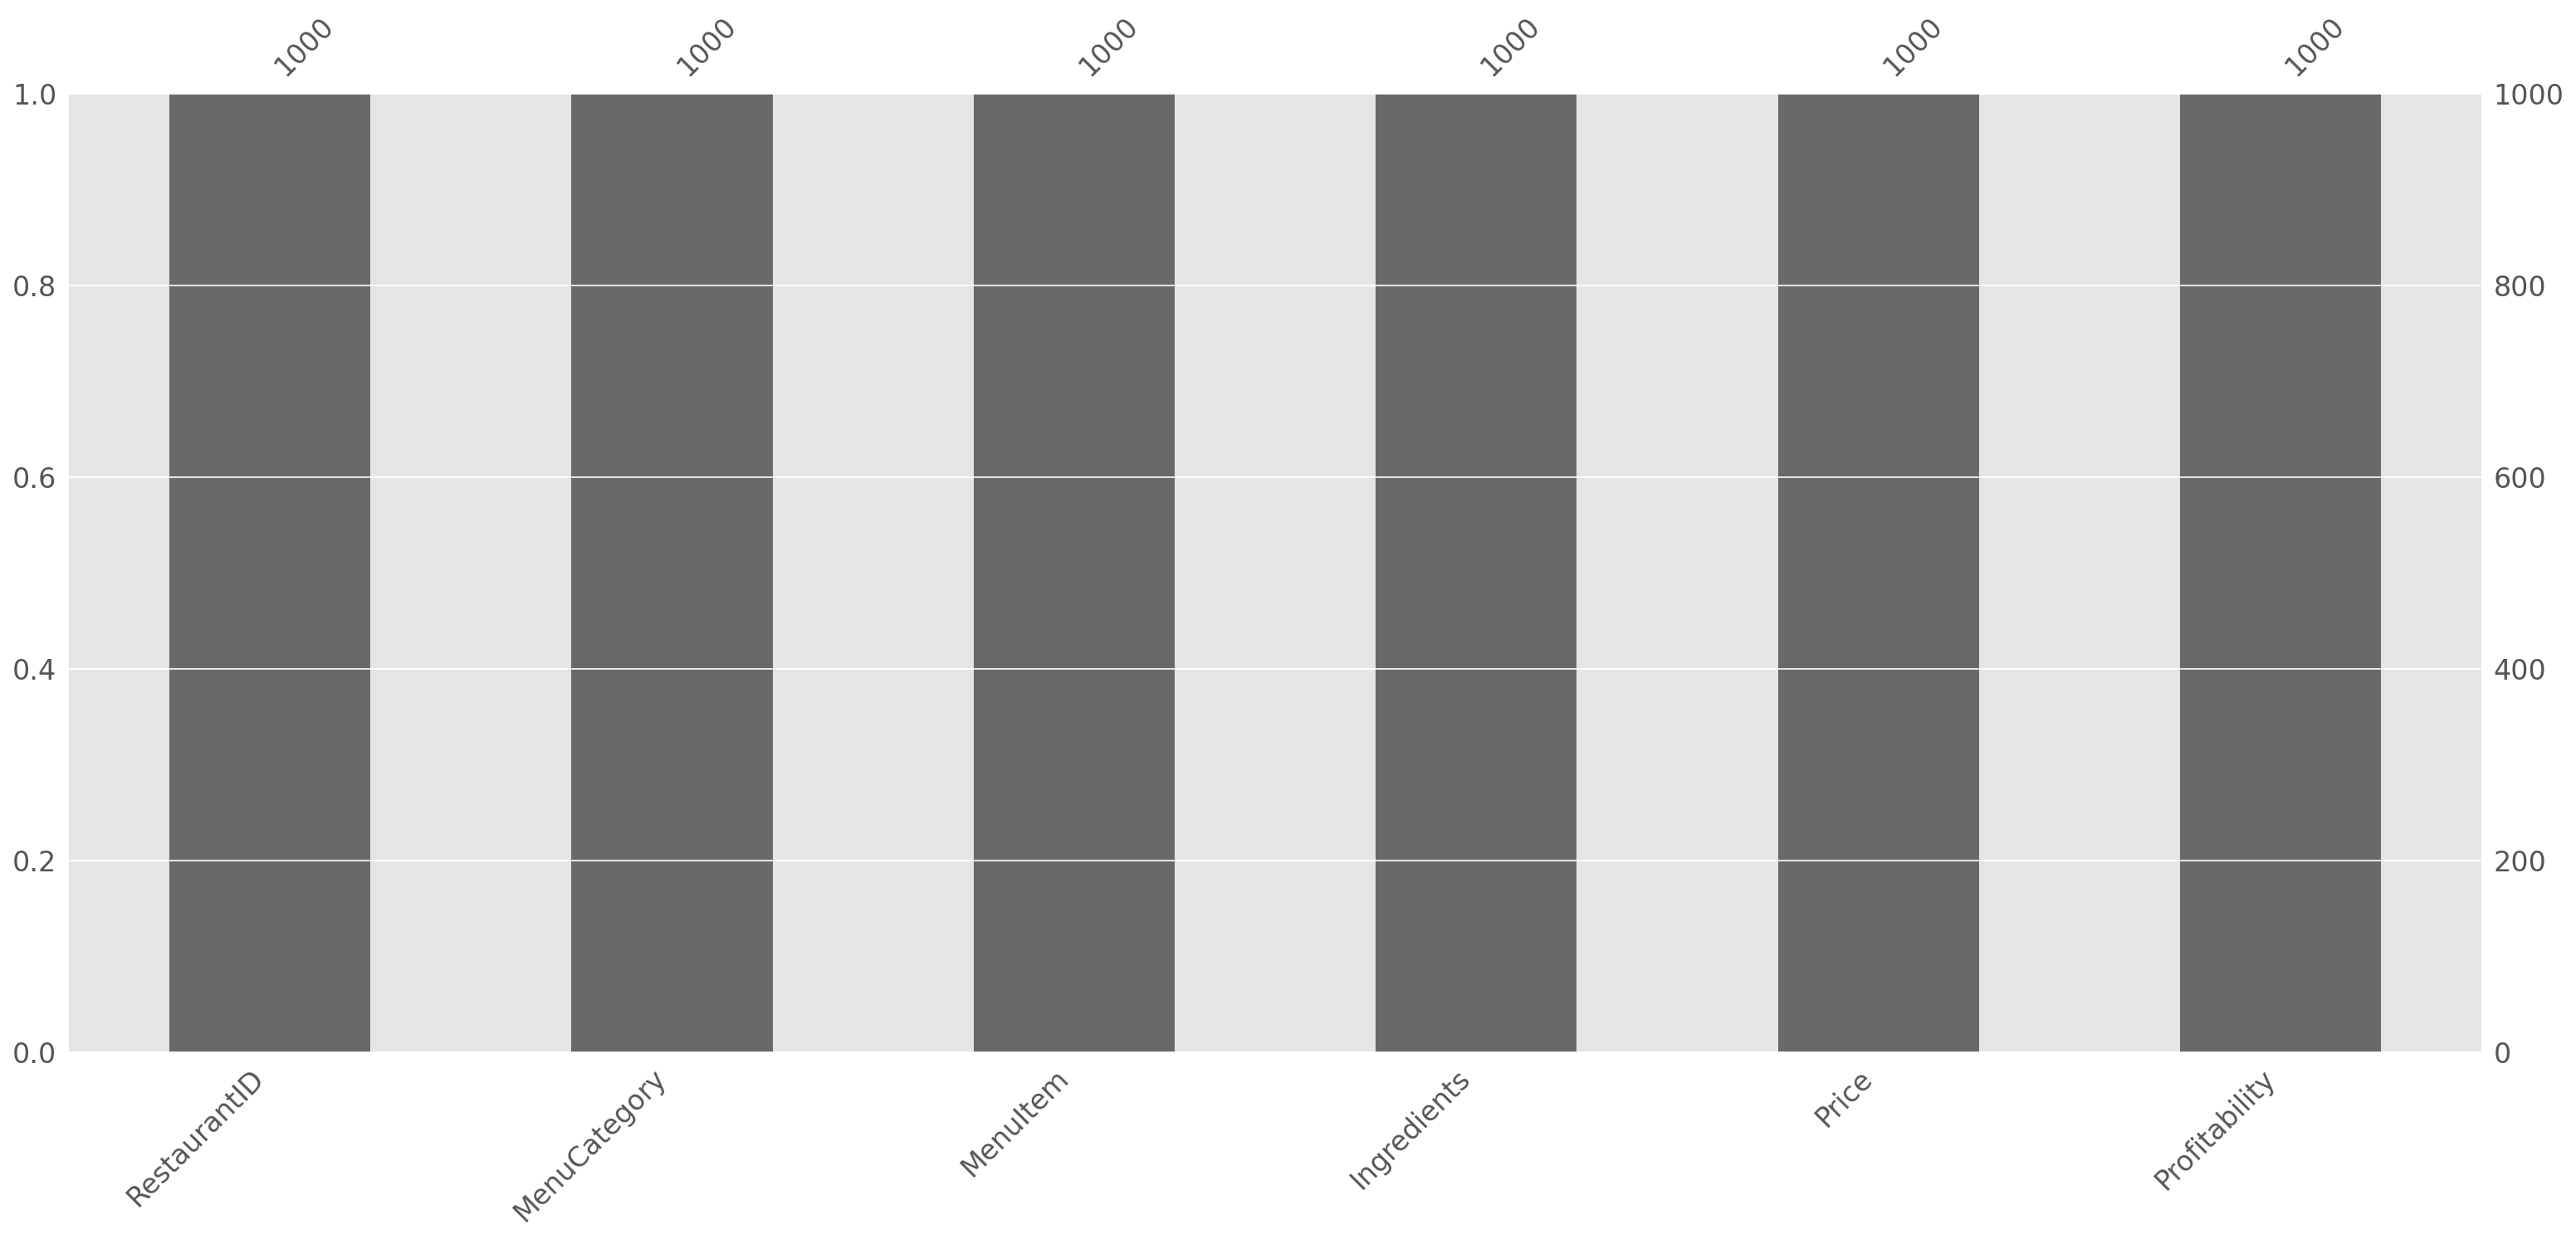

In [7]:
msno.bar(df)


Price Data skewness : 0.3589500550270436


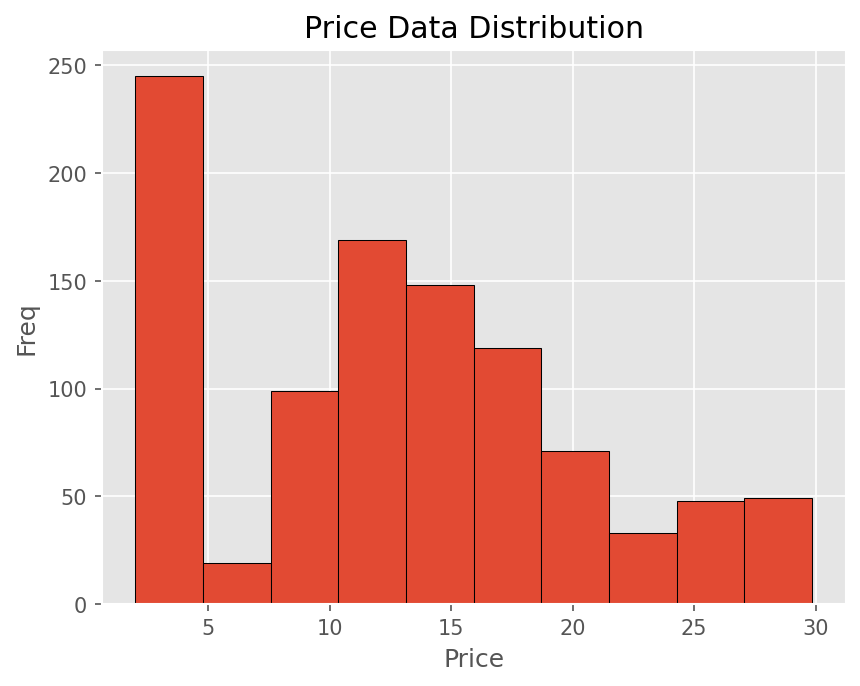

In [8]:
# Visualize the distribution of numerical data

print(f"Price Data skewness : {df['Price'].skew()}")

plt.hist(df['Price'] , edgecolor = 'black' , bins = 10)
plt.xlabel('Price')
plt.ylabel('Freq')
plt.title('Price Data Distribution')
plt.show()

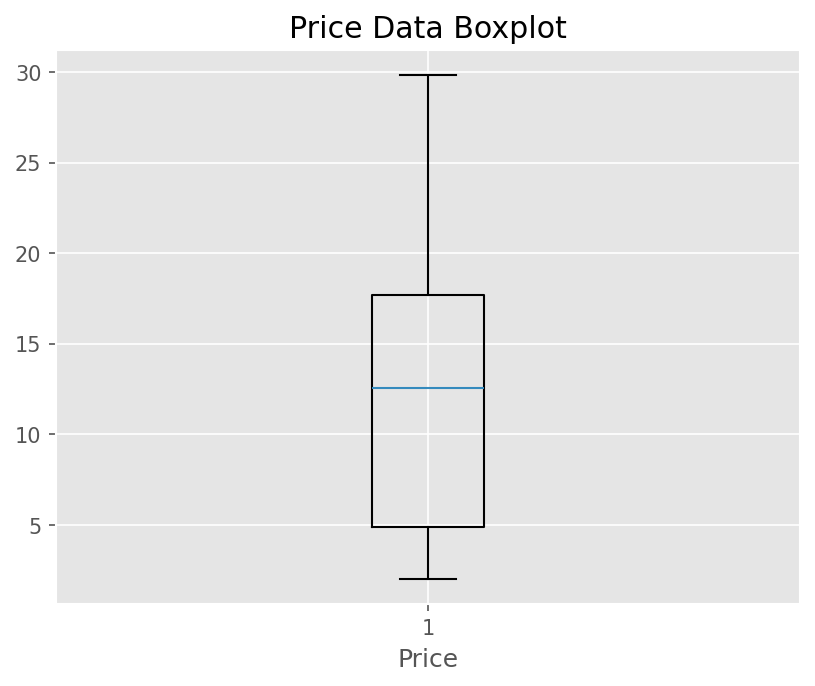

In [9]:
plt.boxplot(df['Price'])
plt.xlabel('Price')
plt.title('Price Data Boxplot')
plt.show()

In [10]:
obj_data = df.select_dtypes('object')

obj_data.head()

,RestaurantID,MenuCategory,MenuItem,Ingredients,Profitability
0,R003,Beverages,Soda,['confidential'],Low
1,R001,Appetizers,Spinach Artichoke Dip,"['Tomatoes', 'Basil', 'Garlic', 'Olive Oil']",Medium
2,R003,Desserts,New York Cheesecake,"['Chocolate', 'Butter', 'Sugar', 'Eggs']",High
3,R003,Main Course,Chicken Alfredo,"['Chicken', 'Fettuccine', 'Alfredo Sauce', 'Pa...",High
4,R002,Main Course,Grilled Steak,"['Chicken', 'Fettuccine', 'Alfredo Sauce', 'Pa...",Medium


In [11]:
cols = obj_data.columns

for col in cols:
    print(f"{col} Nunique : {obj_data[col].nunique()}")

RestaurantID Nunique : 3
MenuCategory Nunique : 4
MenuItem Nunique : 16
Ingredients Nunique : 4
Profitability Nunique : 3


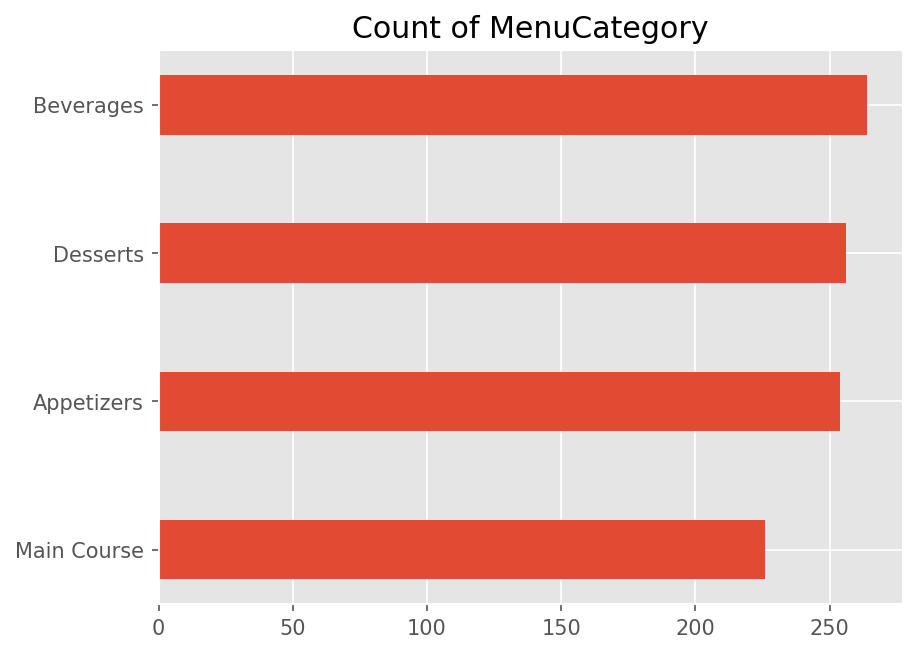

In [12]:
data = obj_data['MenuCategory'].value_counts(ascending = True)
plt.barh(data.index , data.values , height = 0.4)
plt.title('Count of MenuCategory')
plt.show()

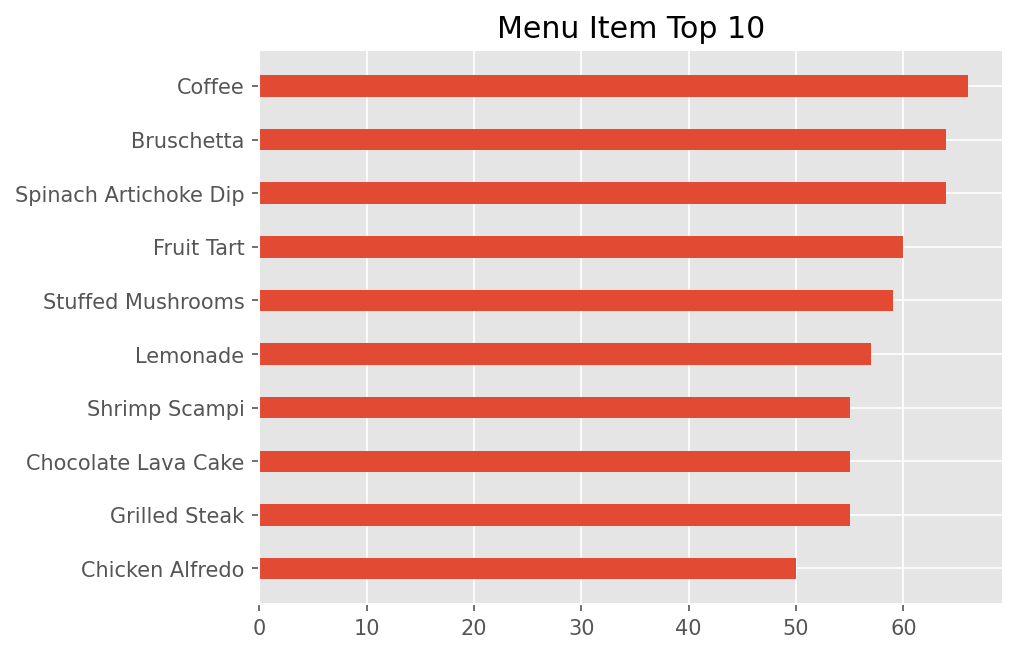

In [13]:
data = obj_data['MenuItem'].value_counts(ascending = True).head(10)
plt.barh(data.index , data.values , height = 0.4)
plt.title('Menu Item Top 10')
plt.show()

In [14]:
# Ingredients

obj_data.groupby(['Ingredients' , 'MenuItem'])['MenuItem'].count()

Ingredients                                             MenuItem             
['Chicken', 'Fettuccine', 'Alfredo Sauce', 'Parmesan']  Chicken Alfredo          50
                                                        Grilled Steak            55
                                                        Shrimp Scampi            55
                                                        Vegetable Stir-Fry       66
['Chocolate', 'Butter', 'Sugar', 'Eggs']                Chocolate Lava Cake      55
                                                        Fruit Tart               60
                                                        New York Cheesecake      71
                                                        Tiramisu                 70
['Tomatoes', 'Basil', 'Garlic', 'Olive Oil']            Bruschetta               64
                                                        Caprese Salad            67
                                                        Spinach Artichoke Dip    6

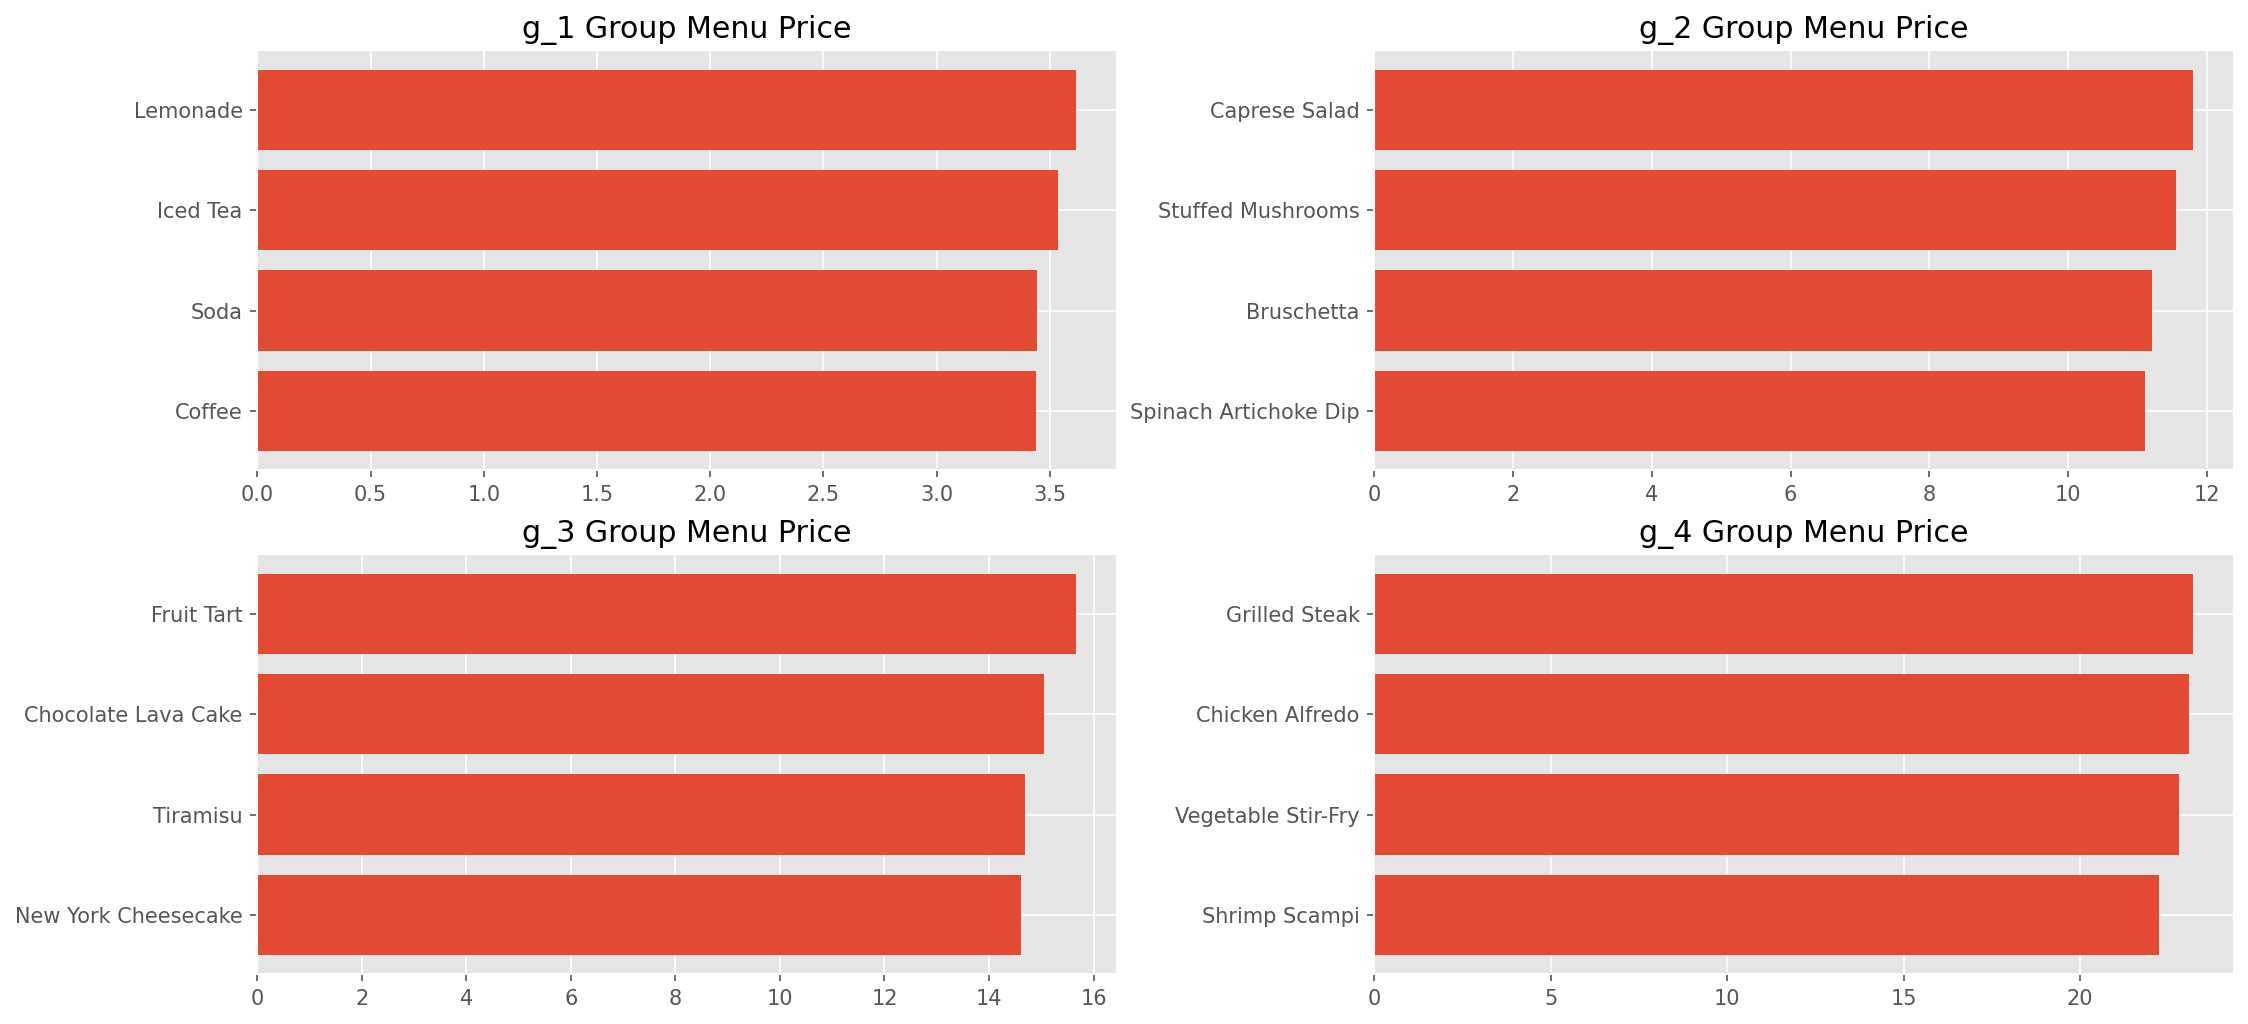

In [15]:
# Price , Profitability

# Price
ingredients = df['Ingredients'].unique()

g1 = df[df['Ingredients'] == ingredients[0]]
g2 = df[df['Ingredients'] == ingredients[1]]
g3 = df[df['Ingredients'] == ingredients[2]]
g4 = df[df['Ingredients'] == ingredients[3]]


group = [g1 , g2 , g3 , g4]

fig , ax = plt.subplots(2 , 2 , figsize = (17 , 8))
plt.subplots_adjust(wspace = 0.3)
for i in range(4):
    row = i // 2
    col = i % 2

    data = group[i].groupby(['MenuItem'])['Price'].mean()\
    .sort_values()
    ax[row][col].barh(data.index , data.values)
    ax[row][col].set_title(f"g_{i + 1} Group Menu Price")

plt.show()

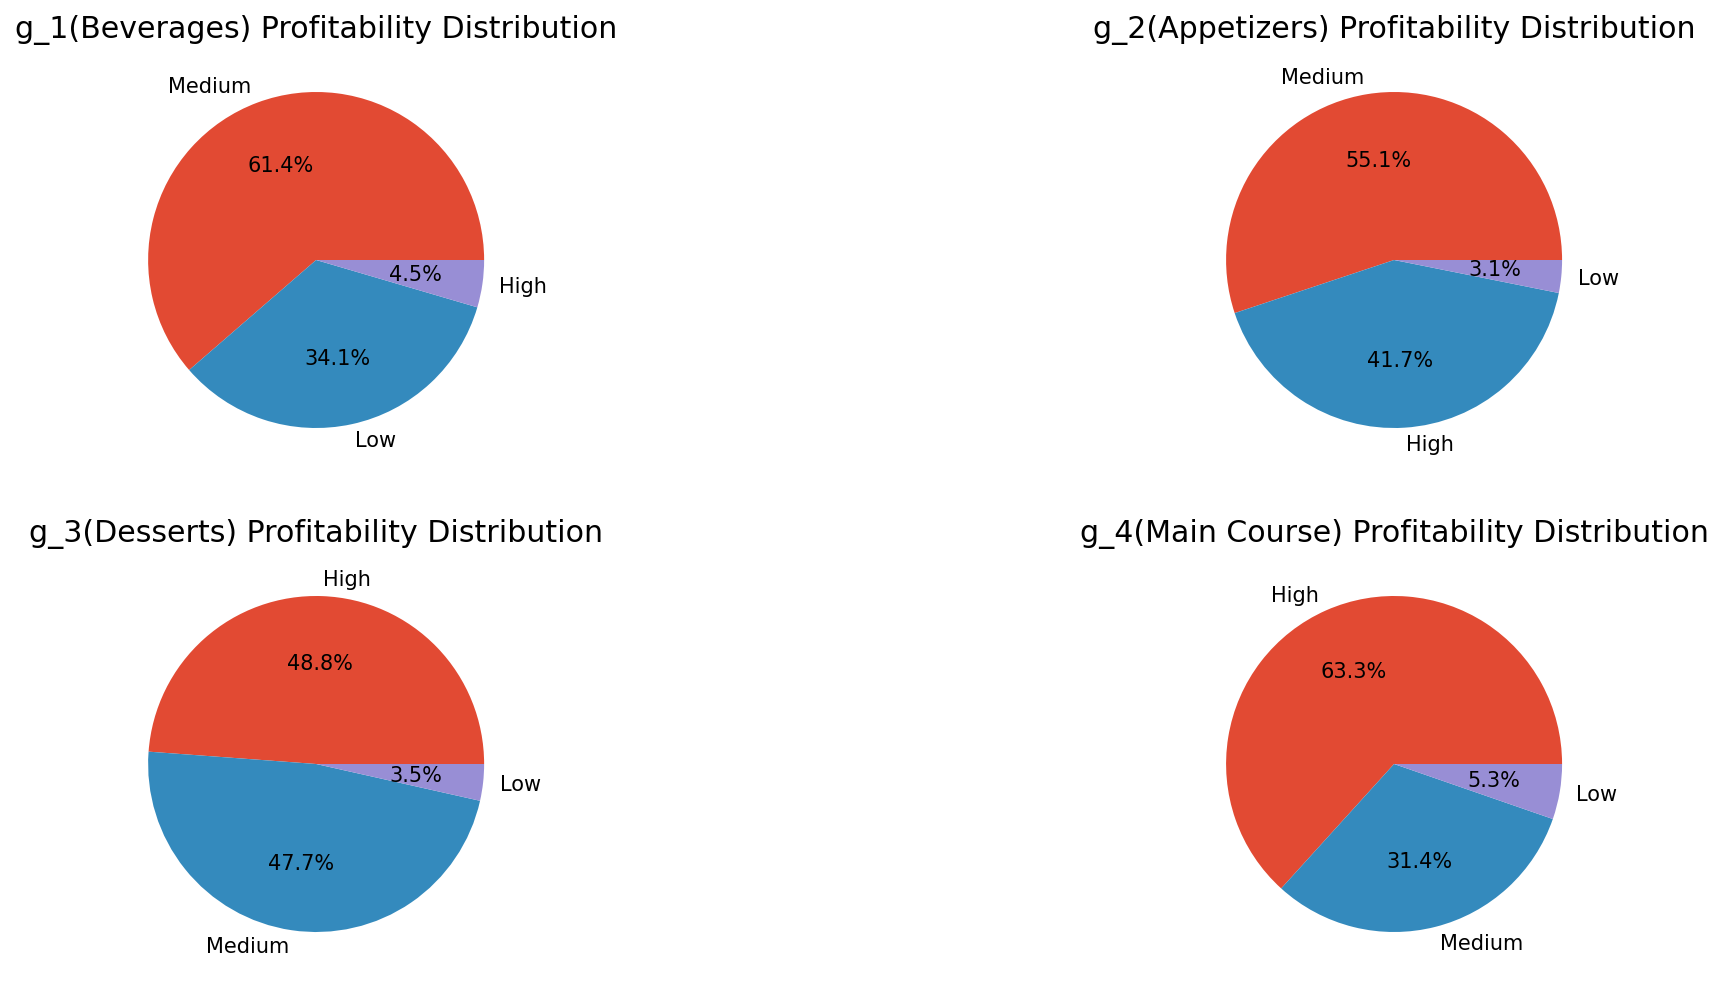

In [16]:
# Profitability

fig , ax = plt.subplots(2 , 2 , figsize = (17 , 8))
for i in range(4):
    row = i // 2
    col = i % 2

    data = group[i]['Profitability'].value_counts()
    ax[row][col].pie(data , labels = data.index , autopct = '%1.1f%%')
    ax[row][col].set_title(f"g_{i + 1}({group[i]['MenuCategory'].unique()[0]}) Profitability Distribution")
    
plt.show()

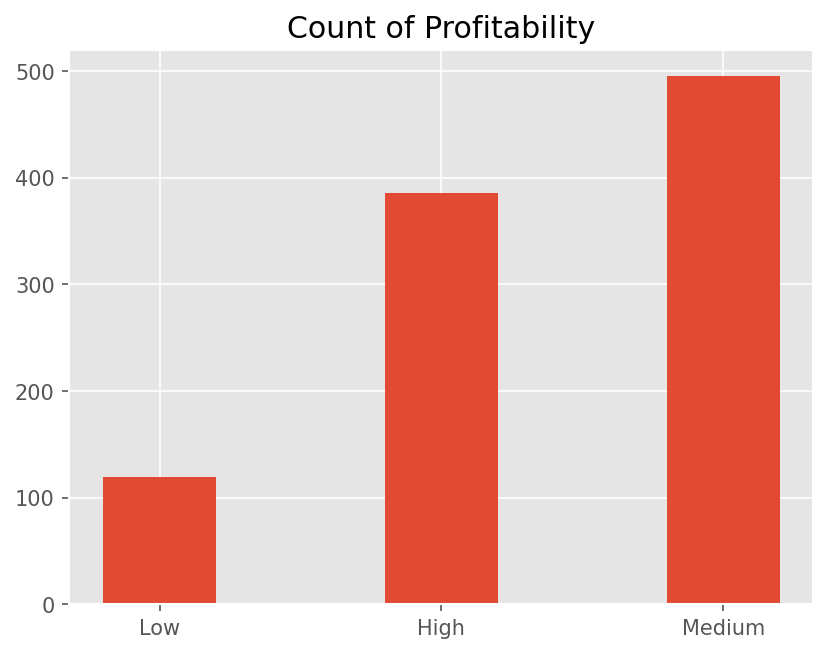

In [17]:
# Profitability

data = obj_data['Profitability'].value_counts(ascending = True)
plt.bar(data.index , data.values , width = 0.4)
plt.title('Count of Profitability')
plt.show()


In [18]:
df.drop(['RestaurantID'] , axis = 1 , inplace = True)


In [19]:
for i in range(df.shape[0]):
    if df.loc[i , 'MenuCategory'] == 'Beverages':
        df.loc[i , 'MenuItem'] = 'A'
    elif df.loc[i , 'MenuCategory'] == 'Appetizers':
        df.loc[i , 'MenuItem'] = 'B'
    elif df.loc[i , 'MenuCategory'] == 'Desserts':
        df.loc[i , 'MenuItem'] = 'C'
    else:
        df.loc[i , 'MenuItem'] = 'D'

In [20]:
encoder = LabelEncoder()

df['MenuCategory'] = encoder.fit_transform(df['MenuCategory'])
df['MenuItem'] = encoder.fit_transform(df['MenuItem'])
df['Ingredients'] = encoder.fit_transform(df['Ingredients'])

# target value encoding

df['Profitability'] = encoder.fit_transform(df['Profitability'])

In [21]:
df.head()

,MenuCategory,MenuItem,Ingredients,Price,Profitability
0,1,0,3,2.55,1
1,0,1,2,11.12,2
2,2,2,1,18.66,0
3,3,3,0,29.55,0
4,3,3,0,17.73,2


In [22]:
target = df['Profitability']
df.drop(['Profitability'] , axis = 1 , inplace = True)

In [23]:
trainX , testX , trainY , testY = train_test_split(df , target , test_size = 0.2 , random_state = 42)

In [24]:
model = xgb.XGBClassifier()

model.fit(trainX , trainY)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [25]:
print(f"train data r2 : {model.score(trainX , trainY)}")
print(f"test data r2 : {model.score(testX , testY)}")

y_pred = model.predict(testX)

print(classification_report(testY , y_pred))

train data r2 : 0.93
test data r2 : 0.91
              precision    recall  f1-score   support

           0       0.90      0.95      0.92        77
           1       0.88      0.56      0.68        25
           2       0.92      0.97      0.95        98

    accuracy                           0.91       200
   macro avg       0.90      0.83      0.85       200
weighted avg       0.91      0.91      0.90       200



In [26]:
#oversampling
smote = SMOTE()

df_resampled , target_resampled = smote.fit_resample(df , target)

In [27]:
print(f"Data size before Oversampling : {df.shape}")
print(f"Data size before Oversampling : {target.shape}")
print(f"Data size after Oversampling : {df_resampled.shape}")
print(f"Data size after Oversampling : {target_resampled.shape}")

Data size before Oversampling : (1000, 4)
Data size before Oversampling : (1000,)
Data size after Oversampling : (1485, 4)
Data size after Oversampling : (1485,)


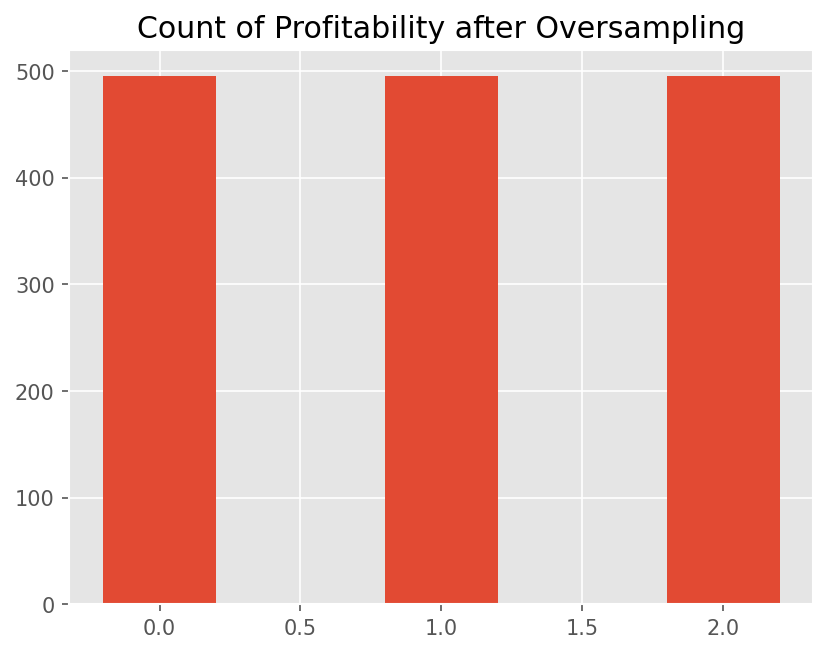

In [28]:
# Profitability

data = target_resampled.value_counts()
plt.bar(data.index , data.values , width = 0.4)
plt.title('Count of Profitability after Oversampling')
plt.show()

In [29]:
trainX , testX , trainY , testY = train_test_split(df_resampled , target_resampled 
                                                   , test_size = 0.2 , random_state = 42)

In [30]:
model = xgb.XGBClassifier()

model.fit(trainX , trainY)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [31]:
# Model evaluation

print(f"train data r2 : {model.score(trainX , trainY)}")
print(f"test data r2 : {model.score(testX , testY)}")

y_pred = model.predict(testX)

print(classification_report(testY , y_pred))

train data r2 : 0.8956228956228957
test data r2 : 0.8451178451178452
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        91
           1       0.89      0.72      0.79       109
           2       0.84      0.96      0.89        97

    accuracy                           0.85       297
   macro avg       0.85      0.85      0.84       297
weighted avg       0.85      0.85      0.84       297



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

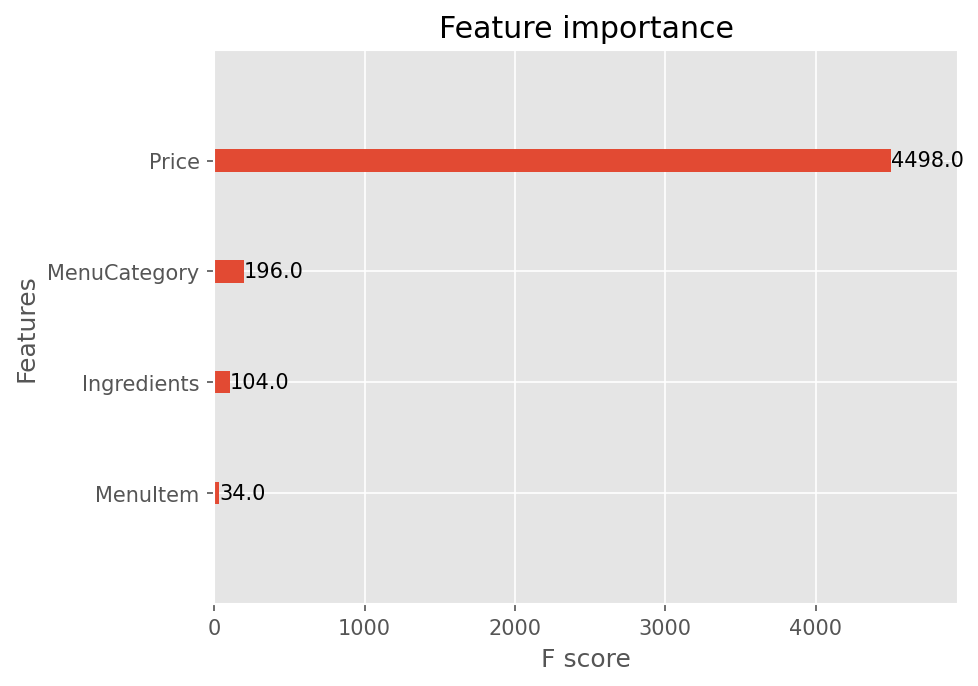

In [32]:
xgb.plot_importance(model)


In [33]:
kfold = KFold(n_splits = 5)

In [34]:
model = xgb.XGBClassifier()

params = {
    'n_estimators' : [100 , 200 , 300] ,
    'max_depth' : [3 , 7] ,
    'min_child_weight' : [1 , 3] ,
    'colsample_bytree' : [0.5 , 0.8]
}

gcv = GridSearchCV(model , param_grid = params , cv = kfold , scoring = 'accuracy' ,
                  verbose = 1)
gcv.fit(trainX , trainY)

best = gcv.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [35]:
print(f"best model score : {gcv.best_score_}")
print(f"params : {gcv.best_params_}")

best model score : 0.8619473105697976
params : {'colsample_bytree': 0.5, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 200}


In [36]:
model = xgb.XGBClassifier(
    n_estimators = 100 ,
    max_depth = 3 ,
    min_child_weight = 1 ,
    colsample_bytree = 0.8
)

model.fit(trainX , trainY)

# Model evaluation

print(f"train data r2 : {model.score(trainX , trainY)}")
print(f"test data r2 : {model.score(testX , testY)}")

y_pred = model.predict(testX)

print(classification_report(testY , y_pred))

train data r2 : 0.8905723905723906
test data r2 : 0.835016835016835
              precision    recall  f1-score   support

           0       0.82      0.91      0.86        91
           1       0.91      0.66      0.77       109
           2       0.79      0.96      0.87        97

    accuracy                           0.84       297
   macro avg       0.84      0.84      0.83       297
weighted avg       0.85      0.84      0.83       297



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

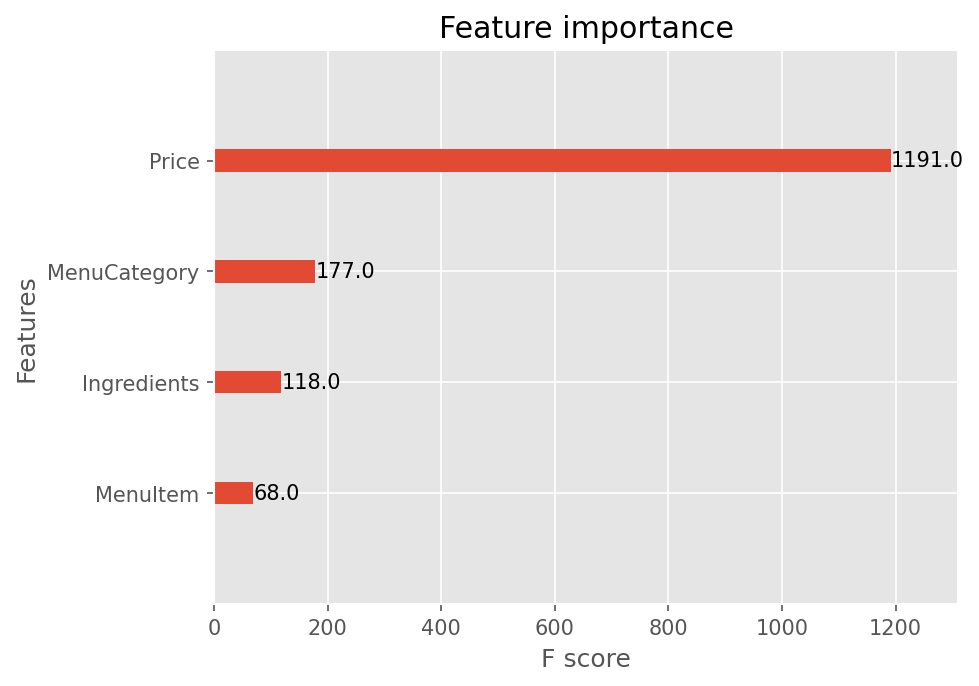

In [37]:
xgb.plot_importance(model)
